# Description

It reads the final results computed by the notebook `021-prediction_performance.ipynb` and create figures.

# Modules loading

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.display import display
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import conf

# Settings

In [3]:
OUTPUT_DIR = conf.RESULTS["DRUG_DISEASE_ANALYSES"] / "lincs"
display(OUTPUT_DIR)
assert OUTPUT_DIR.exists()

PosixPath('/opt/data/results/drug_disease_analyses/lincs')

In [4]:
OUTPUT_FIGURES_DIR = Path(
    conf.MANUSCRIPT["FIGURES_DIR"], "drug_disease_prediction"
).resolve()
display(OUTPUT_FIGURES_DIR)
OUTPUT_FIGURES_DIR.mkdir(parents=True, exist_ok=True)

PosixPath('/opt/manuscript/content/images/drug_disease_prediction')

# Load predictions

## Across all tissues

In [5]:
input_file = Path(OUTPUT_DIR, "predictions", "predictions_results.pkl").resolve()
display(input_file)

PosixPath('/opt/data/results/drug_disease_analyses/lincs/predictions/predictions_results.pkl')

In [6]:
predictions = pd.read_pickle(input_file)

In [7]:
predictions.shape

(316540, 8)

In [8]:
predictions.head()

,trait,drug,score,true_class,method,n_top_genes,data,tissue
0,DOID:0050741,DB00215,323.0,1,Gene-based,100.0,spredixcan-mashr-zscores-Pancreas-data,Pancreas
1,DOID:0050741,DB00704,230.0,1,Gene-based,100.0,spredixcan-mashr-zscores-Pancreas-data,Pancreas
2,DOID:0050741,DB00822,199.0,1,Gene-based,100.0,spredixcan-mashr-zscores-Pancreas-data,Pancreas
3,DOID:10283,DB00014,115.0,1,Gene-based,100.0,spredixcan-mashr-zscores-Pancreas-data,Pancreas
4,DOID:10283,DB00175,167.0,0,Gene-based,100.0,spredixcan-mashr-zscores-Pancreas-data,Pancreas


## Aggregated (across all tissues)

In [9]:
input_file = Path(
    OUTPUT_DIR, "predictions", "predictions_results_aggregated.pkl"
).resolve()
display(input_file)

PosixPath('/opt/data/results/drug_disease_analyses/lincs/predictions/predictions_results_aggregated.pkl')

In [10]:
predictions_avg = pd.read_pickle(input_file)

In [11]:
predictions_avg.shape

(1292, 5)

In [12]:
predictions_avg.head()

,trait,drug,method,score,true_class
0,DOID:0050741,DB00215,Gene-based,359.0,1.0
1,DOID:0050741,DB00215,Module-based,437.8,1.0
2,DOID:0050741,DB00704,Gene-based,395.8,1.0
3,DOID:0050741,DB00704,Module-based,562.8,1.0
4,DOID:0050741,DB00822,Gene-based,556.8,1.0


# Rename methods

In [13]:
predictions["method"].unique()

array(['Gene-based', 'Module-based'], dtype=object)

In [14]:
predictions_avg["method"].unique()

array(['Gene-based', 'Module-based'], dtype=object)

In [15]:
_method_rename = {
    "Module-based": "LV-based",
}

In [16]:
predictions = predictions.replace({"method": _method_rename})

In [17]:
predictions_avg = predictions_avg.replace({"method": _method_rename})

# ROC

In [18]:
methods_names = tuple(predictions["method"].unique())
assert len(methods_names) == 2
display(methods_names)

('Gene-based', 'LV-based')

In [19]:
methods_colors = {methods_names[0]: "red", methods_names[1]: "blue"}

## Functions

In [20]:
from sklearn.metrics import roc_auc_score, roc_curve

In [21]:
def plot_roc(data, method_key, fig, ax, remove_non_informative=False):
    roc_auc = roc_auc_score(data["true_class"], data["score"])

    fpr, tpr, thresholds = roc_curve(data["true_class"], data["score"])

    if remove_non_informative:
        cond = (fpr < 1.0) & (tpr < 1.0)
        fpr = fpr[cond]
        tpr = tpr[cond]
        print(f"  Points for ROC curve (after prunning): {len(fpr)}")

    label = f"{method_key} - AUC: {roc_auc:.3f}"
    sns.lineplot(
        x=fpr,
        y=tpr,
        estimator=None,
        label=label,
        ax=ax,
        linewidth=1.00,
        linestyle="-",
        color=methods_colors[method_key],
    )

In [22]:
def plot_roc_for_methods(selected_methods, fig, ax):
    for method_name in selected_methods:
        data = predictions_avg[predictions_avg["method"] == method_name]
        plot_roc(data, method_name, fig, ax)

    ax.plot([0.0, 1.00], [0.0, 1.00], color="gray", linewidth=1.25, linestyle="-")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_xlim([0.0, 1.01])
    ax.set_ylim([0.0, 1.01])
    ax.set_aspect("equal")
    ax.legend(loc="lower right")

## Plots

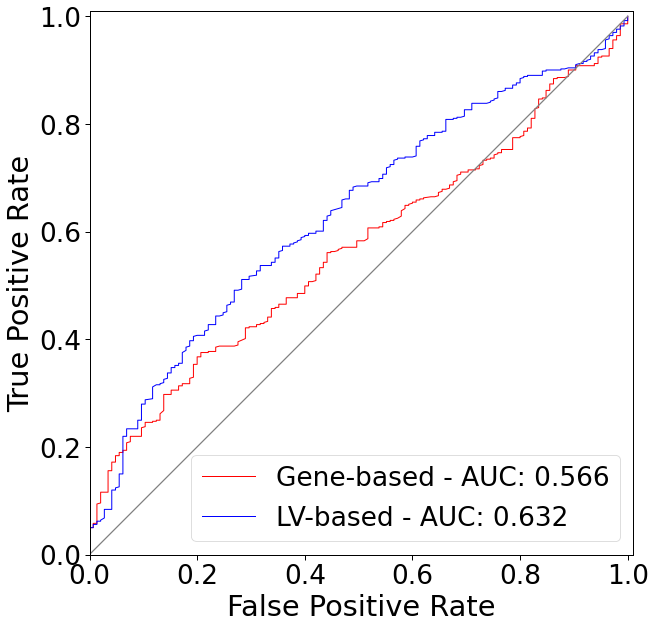

In [23]:
with sns.plotting_context("paper", font_scale=3.00):
    fig, ax = plt.subplots(figsize=(10, 10))
    plot_roc_for_methods(methods_names, fig, ax)

# Precision-Recall

## Functions

In [24]:
from sklearn.metrics import precision_recall_curve, average_precision_score

In [25]:
def plot_pr_raw_data(recall, precision, label, **kwargs):
    sns.lineplot(x=recall, y=precision, label=label, **kwargs)


def plot_pr(data, method_key, fig, ax, estimator=None, remove_non_informative=False):
    precision, recall, thresholds = precision_recall_curve(
        data["true_class"], data["score"]
    )
    if remove_non_informative:
        cond = recall < 1.0
        recall = recall[cond]
        precision = precision[cond]

    ap = average_precision_score(data["true_class"], data["score"])

    label = f"{method_key} - AP: {ap:.3f}"
    plot_pr_raw_data(
        recall,
        precision,
        label,
        estimator=estimator,
        ax=ax,
        linewidth=1.00,
        linestyle="-",
        color=methods_colors[method_key],
    )

In [26]:
def get_random_classifier_pr(data, reps=10, min_val=0, max_val=1):
    random_precision = []
    random_recall = []
    random_average_precision = []

    for i in range(reps):
        random_score = np.random.permutation(data["score"].values)
        rp, rr, _ = precision_recall_curve(data["true_class"], random_score)
        random_precision.extend(rp)
        random_recall.extend(rr)
        random_average_precision.append(
            average_precision_score(data["true_class"], random_score)
        )

    return (
        np.array(random_recall),
        np.array(random_precision),
        np.array(random_average_precision),
    )

In [27]:
def plot_pr_for_methods(selected_methods, fig, ax):
    for method_name in selected_methods:
        data = predictions_avg[predictions_avg["method"] == method_name]
        plot_pr(data, method_name, fig, ax)

    # add random classifier
    random_recall, random_precision, random_averages = get_random_classifier_pr(
        data, reps=100
    )

    random_label = f"Random - AP: {random_averages.mean():.3f}"
    plot_pr_raw_data(
        random_recall,
        random_precision,
        random_label,
        estimator="mean",
        ax=ax,
        ci="sd",
        color="gray",
    )

    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.set_xlim([0.0, 1.01])
    ax.set_ylim([0.60, 1.02])
    ax.legend(loc="lower right")

## Plots

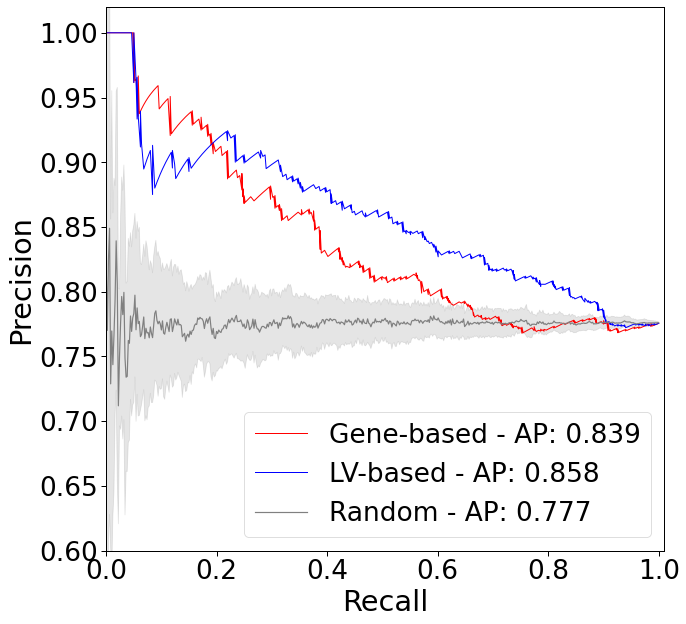

In [28]:
with sns.plotting_context("paper", font_scale=3.00):
    fig, ax = plt.subplots(figsize=(10, 10))
    plot_pr_for_methods(methods_names, fig, ax)

# Combined plots

PosixPath('/opt/manuscript/content/images/drug_disease_prediction/roc_pr_curves.svg')

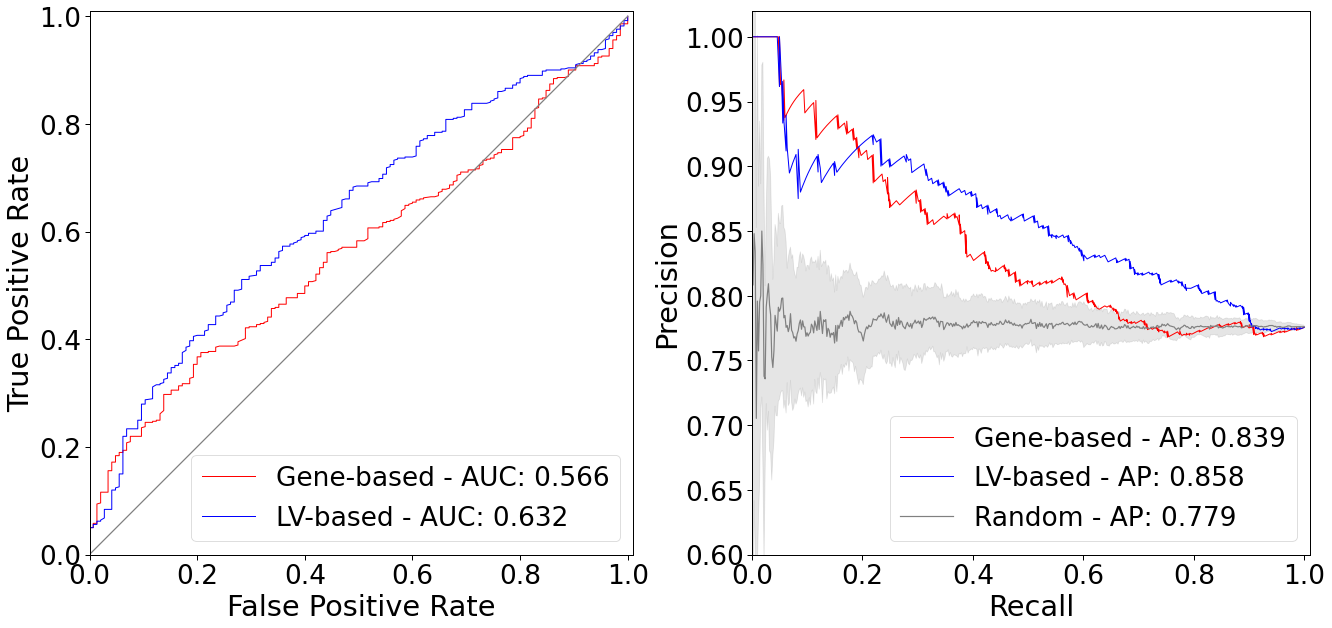

In [29]:
with sns.plotting_context("paper", font_scale=3.00):
    fig, ax = plt.subplots(figsize=(22, 10))

    ax = plt.subplot(1, 2, 1)
    plot_roc_for_methods(methods_names, fig, ax)

    ax = plt.subplot(1, 2, 2)
    plot_pr_for_methods(methods_names, fig, ax)

    output_filepath = OUTPUT_FIGURES_DIR / f"roc_pr_curves.svg"
    display(output_filepath)

    plt.savefig(
        output_filepath,
        bbox_inches="tight",
        facecolor="white",
    )